<a href="https://colab.research.google.com/github/maashha/Nonogram-solver/blob/main/Nonogram_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
pip install --upgrade pip

In [54]:
pip install pycosat

In [55]:
import pycosat

In [56]:
import os

In [57]:
import time

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [59]:
def existence(series, length, sizes, number):
    final = []
    maximum = 0
    minimum = -1
    non_empty = []
    uniqueness = []
    for group in range(len(series)):
        starting_positions = []
        if group!=0:
            #move borders on the length of the previous block
            left += series[group-1] + 1
            right += series[group-1] + 1
        else:
            left = 0
            right = length + 1 - sum(series[0:]) - len(series)
        for possible in range(left, right+1):
            position = (possible+1)+sizes+length*(number+group)
            starting_positions.append(position) #add all possible positions of the first cell of the block to one array
            non_empty.append(position)
            if maximum<position:
                maximum = position
            if minimum > position or minimum == -1:
                minimum = position
            for can in range(possible+1, right+1):
                uniqueness.append([-position, -((can+1)+sizes+length*(number+group))]) #exclude situations where one block has two starting cells
        final.append(starting_positions) #all of such starting_positions for one row or column
    return [final, uniqueness, maximum, minimum, non_empty]

In [60]:
def intersection(sets, lengths, amount):
    intersect = []
    for section_1 in range(len(sets)):
        for section_2 in range(section_1+1, len(sets)): #choose two sets of starting positions of the blocks
            for first in range(len(sets[section_1])):
                for second in range(len(sets[section_2])): #add elements of the first array in pairs with elements of the second, excluding their intersection
                    if abs((sets[section_1][first]) - (sets[section_2][second])) % amount < sum(lengths[section_1:section_2]) + (section_2-section_1) and abs((sets[section_1][first]) - (sets[section_2][second]))>=amount:
                        intersect.append([-(sets[section_1][first]), -(sets[section_2][second])])
                        if first>=3:
                            intersect.append([-(sets[section_1][first]), -(sets[section_2][first-3])])
    return intersect

In [61]:
def cell_rows(mx, size, lenn, start, mn, something, liine,pr):
    all_cells = []
    no = []
    empty = []
    se = []
    y = {}
    for i in range(start+1, start+lenn+1):
        cells = [-i]
        if i%lenn!=0:
            for j in range(mn+i%lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn]):
                        se.append([-j,n])
                        if n in y.keys():
                            y[n].append(j)
                        else:
                            y[n] = [-n,j]
                    empty.append([i,-j])
        else:
            for j in range(mn+lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn-1]):
                        se.append([-j,n])
                        if n in y.keys():
                            y[n].append(j)
                        else:
                            y[n] = [-n,j]
                    empty.append([i,-j])
        all_cells.append(cells)
        all_cells = []
    return [se, empty, no,y]

In [62]:
def cell_columns(mx, size, lenn, start, mn, something, amoun, nuum, liine,pr):
    all_cells = []
    no = []
    empty = []
    se = []
    yw = {}
    for i in range(start+1, start+lenn+1):
        yw[((i-1)%lenn)*amoun+(i-1)//lenn+1] = [-(((i-1)%lenn)*amoun+(i-1)//lenn+1)]
    for i in range(start+1, start+lenn+1):
        cells = [-(((i-1)%lenn)*amoun+(i-1)//lenn+1)]
        if i%lenn!=0:
            for j in range(mn+i%lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn]):
                        se.append([-j,((n-1)%lenn)*amoun+(n-1)//lenn+1])
                        yw[((n-1)%lenn)*amoun+(n-1)//lenn+1].append(j)
                    empty.append([((i-1)%lenn)*amoun+(i-1)//lenn+1,-j])
        else:
            for j in range(mn+lenn-1, mx+1, lenn):
                if j not in no and j not in something:
                    no.append([-j])
                else:
                    cells.append(j)
                    for n in range(i, i+liine[(j-pr)//lenn-1]):
                        se.append([-j,((n-1)%lenn)*amoun+(n-1)//lenn+1])
                        yw[((n-1)%lenn)*amoun+(n-1)//lenn+1].append(j)
                    empty.append([((i-1)%lenn)*amoun+(i-1)//lenn+1,-j])
        all_cells.append(cells)
    return [se, empty, no, yw]

0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0
0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0
0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0
0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0
1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1
1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1
1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1
0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0
0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0


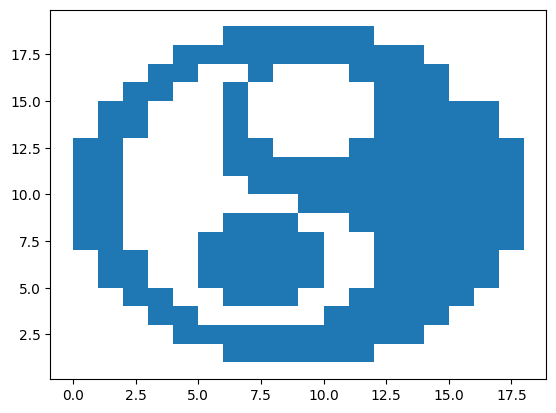

0.6550157070159912
0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0
0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0
0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1
1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1
1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1
1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0


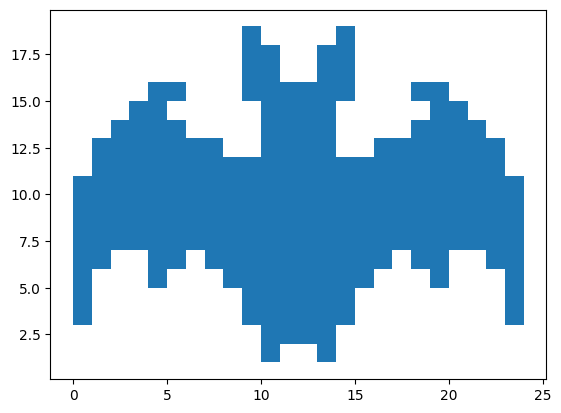

0.8966233730316162
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0

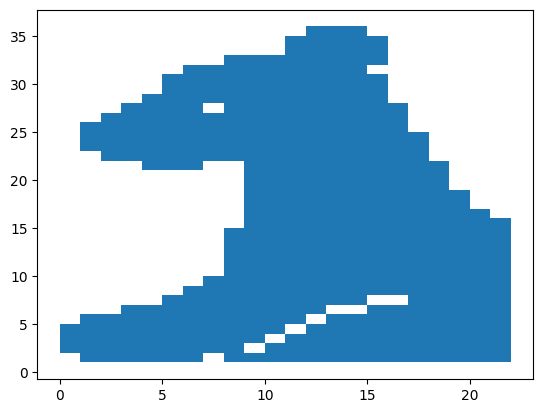

1.7314550876617432
0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0
0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0
0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0
0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0
0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0
0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0
0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0
0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0
0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0
1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0
1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1

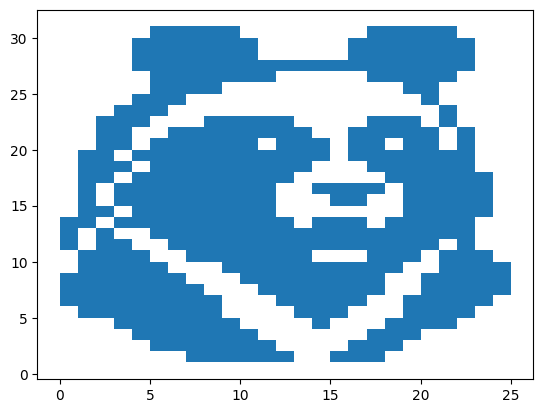

1.572685718536377
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0
1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0
1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 1 1 1 1 

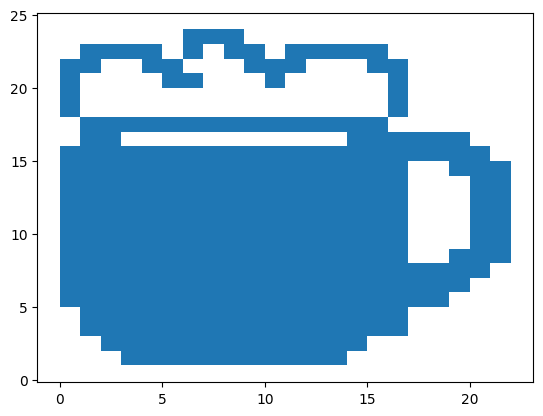

0.9661664962768555
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 1 0 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 0 1 1 1 1 1 1 1 1 1 1 0
1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0


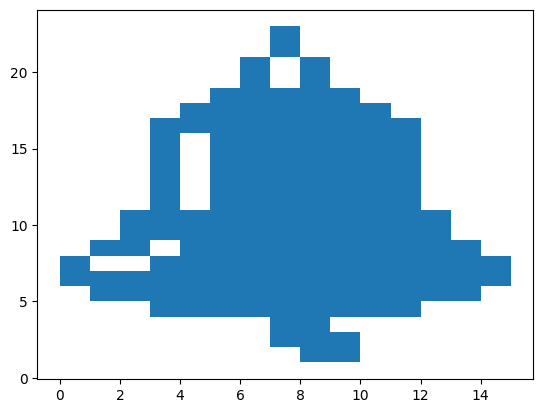

0.6041436195373535
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1

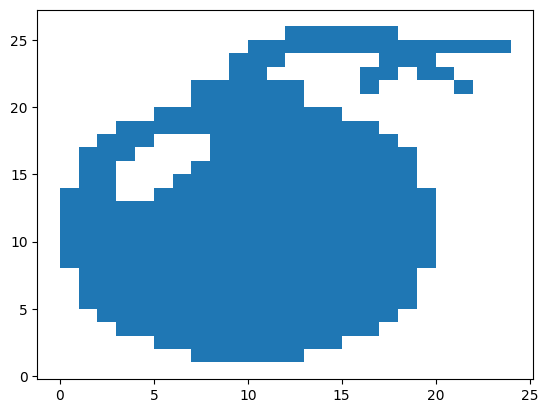

1.1833937168121338
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1

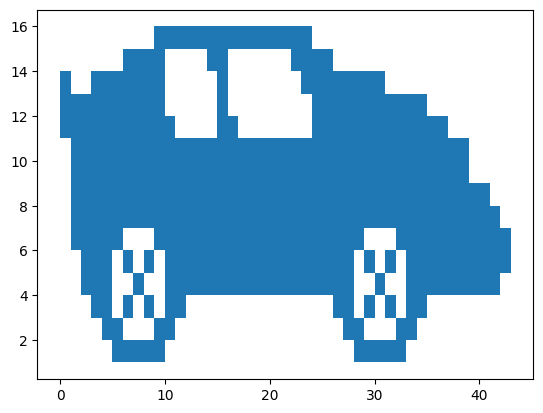

1.2837786674499512
0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0
1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0
1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0
1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0
0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0


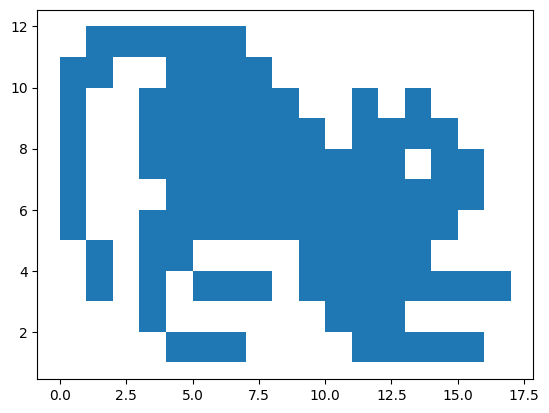

0.4631984233856201
0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0
0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1
1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1
1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1
1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1
1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1
1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1
1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1
1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1
1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0
0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0
1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1

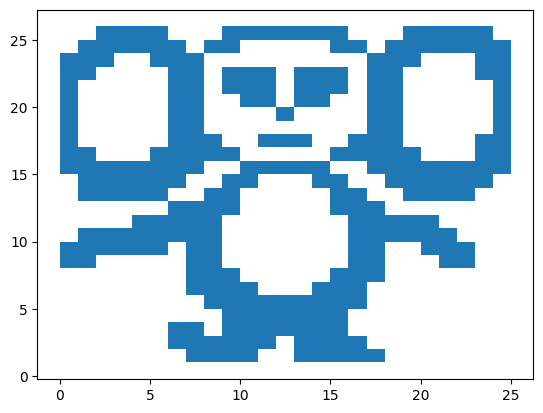

0.9954752922058105
0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0
0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0
0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0
0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0
0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0
0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0
0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0
0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0
0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0
0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0

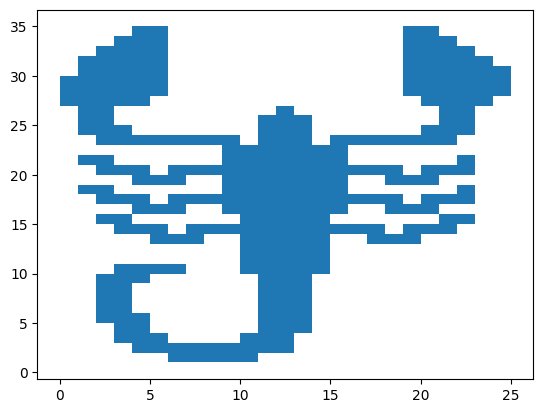

1.4962708950042725
0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0


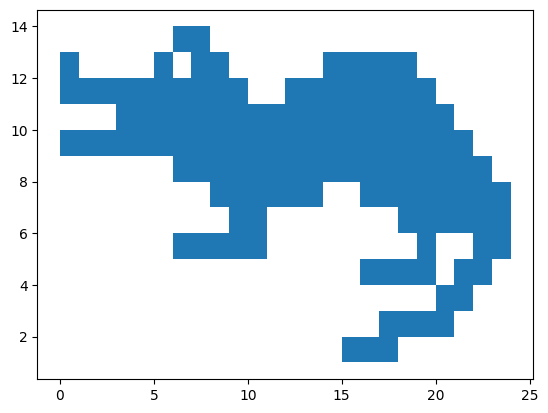

0.5726211071014404
0 0 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1
1 0 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 0 0


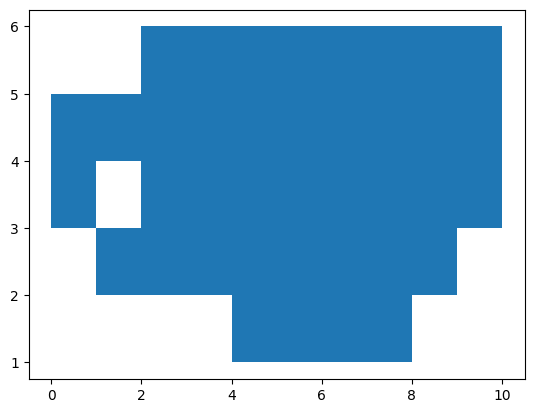

0.26899170875549316
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1
1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0
0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0
0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0
0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0
0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0


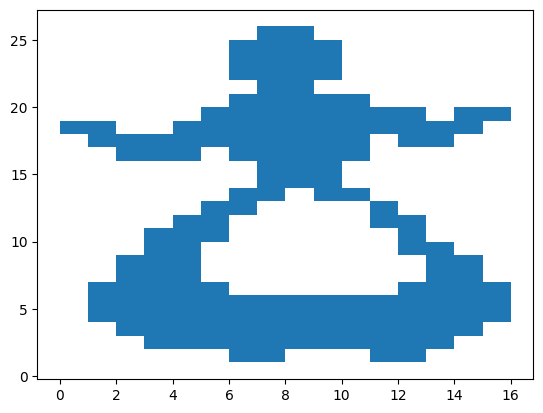

0.684018611907959
0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1
0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1
0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

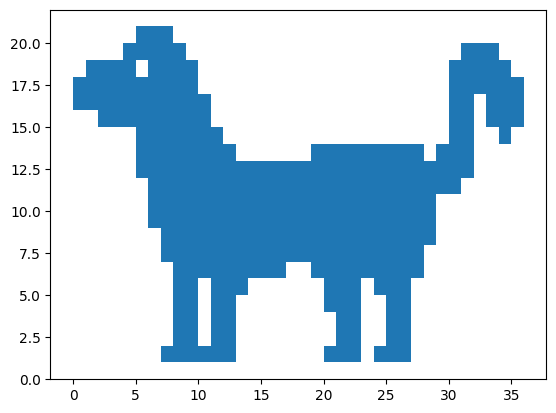

1.427110195159912
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

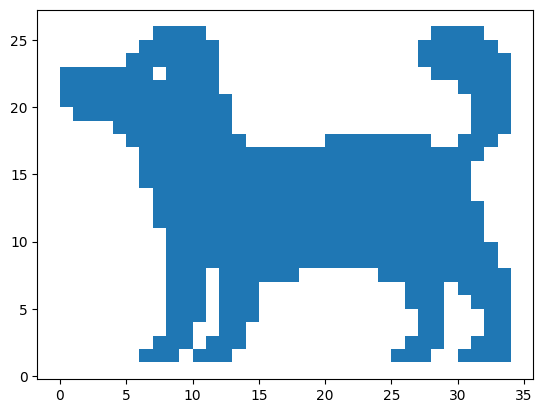

1.7872545719146729
0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 0 0 1 1 1 1 1 0
1 1 1 0 1 1 0 0 1 1 0 1 1 0
1 1 1 1 1 1 0 0 1 1 0 0 0 0
0 1 1 1 1 1 0 0 1 1 0 0 0 0
0 0 1 1 1 1 1 0 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 0 0 1 1 0 1 1 1 1 1 0 0
0 0 0 0 1 1 0 0 1 1 1 1 1 0
0 0 0 0 1 1 0 0 1 1 1 1 1 1
0 0 0 0 1 1 0 0 1 1 0 1 1 1
0 1 1 0 1 1 0 0 1 1 0 1 1 1
0 1 1 1 1 1 0 0 1 1 0 1 1 1
0 1 1 1 1 1 0 0 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 0 0
0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 0 1 1 0 0 1 1 0 0 0 0


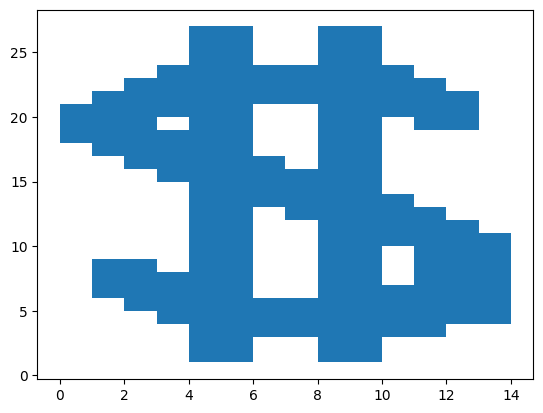

0.7202780246734619
0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0
0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0
0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0
1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0

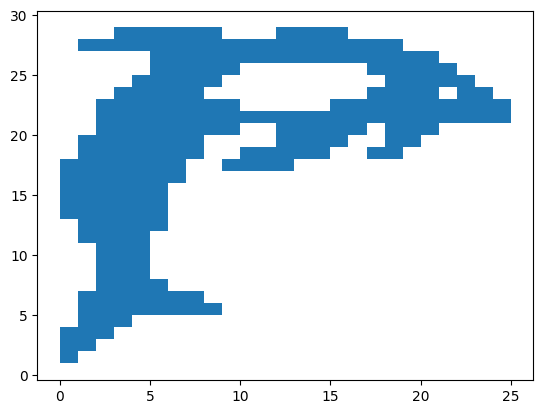

0.9352078437805176
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0
0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 0 1 1 1 0 0 0 0 0 0

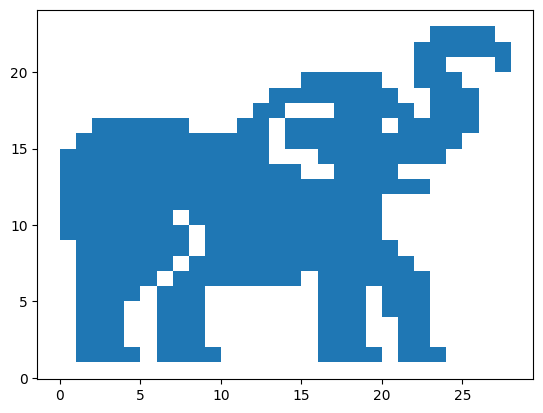

1.1571834087371826
0 0 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 0
1 1 1 0 0 1 0 0 1 1 1
1 1 1 1 0 1 1 0 1 1 1
1 1 1 0 0 1 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 0
0 0 1 1 0 0 0 1 1 0 0
0 0 1 1 0 0 1 1 1 0 0
0 0 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0


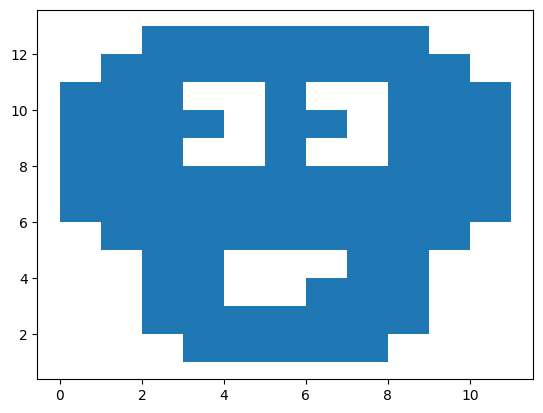

0.4033973217010498
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1


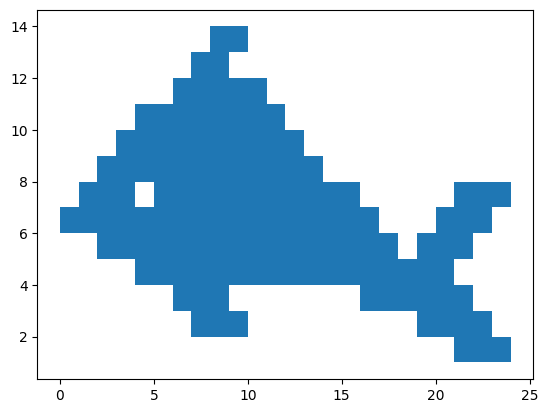

0.5461583137512207
1 0 0 0 0 0 1 1 1 1 1 0 0 0
1 1 0 0 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 1 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 0 0 1 1 1 1 1 1 1 1 1 0
1 0 0 0 0 0 1 1 1 1 1 0 0 0


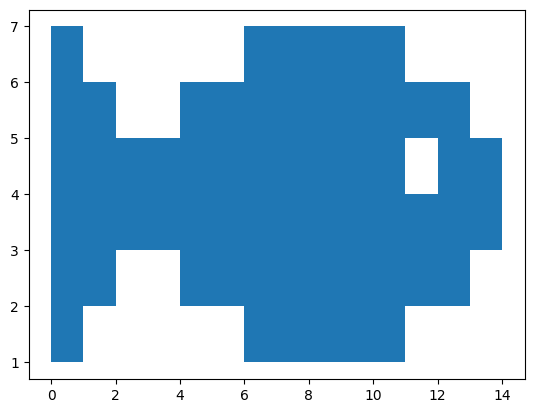

0.342728853225708
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 

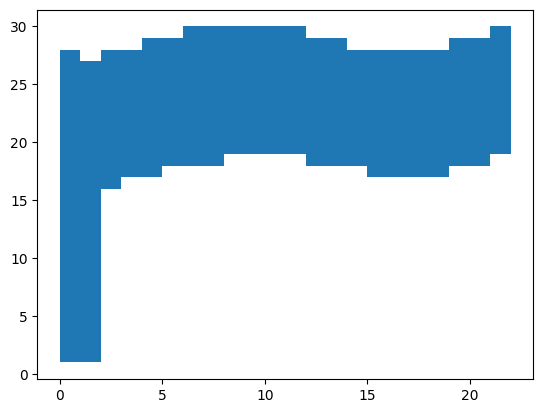

1.1172816753387451
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

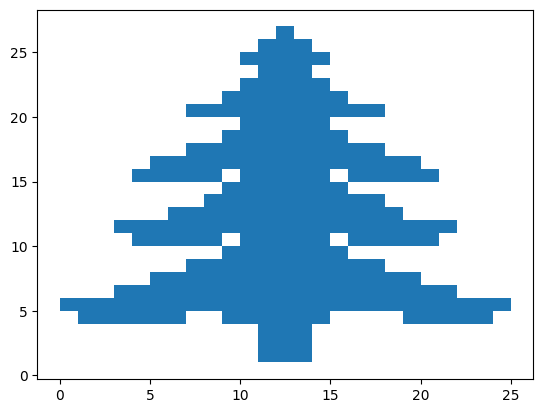

0.9170293807983398
0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0
0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1


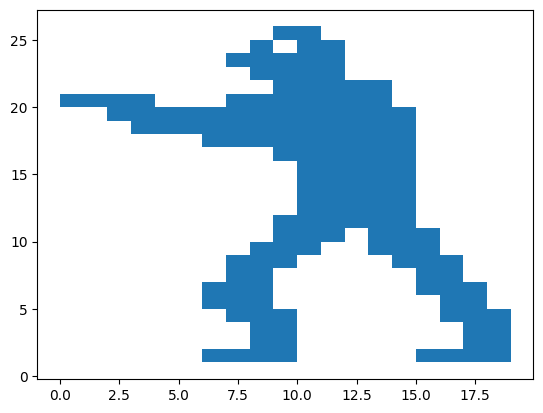

0.7926812171936035
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0
1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1
0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0
0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0
0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0

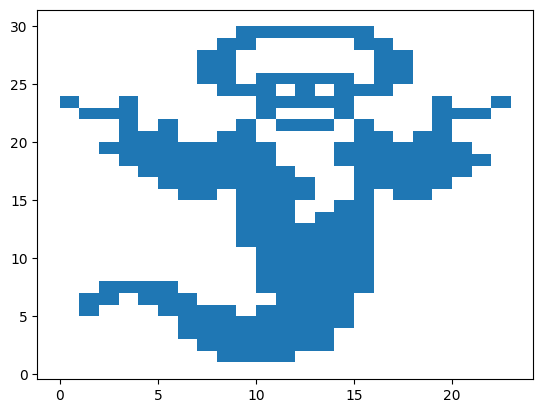

0.922706127166748
0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 1 1 1 0 1 0
0 0 0 0 1 1 0 0 0 1 1 0 0 1 0
0 0 0 1 1 1 1 0 1 1 1 0 0 1 0
0 0 1 1 1 1 1 1 1 1 1 0 0 1 0
0 1 1 1 1 1 1 1 1 1 1 0 0 1 1
0 1 1 0 0 1 1 1 1 1 1 0 0 0 1
1 1 0 0 0 0 1 1 1 1 0 0 0 0 0


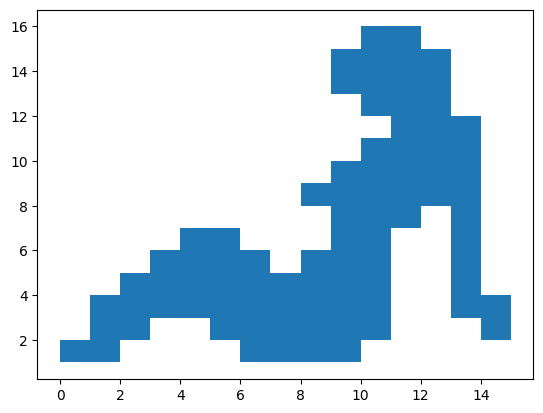

0.5868380069732666
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1
0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1
0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0


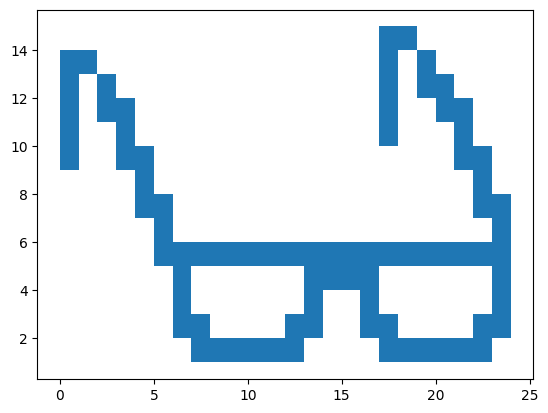

0.5144615173339844
0 0 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1
1 0 1 1 1 1 1 1 1 0 1
1 0 1 1 1 1 1 1 1 0 1
1 0 1 1 1 1 1 1 1 0 1
1 0 1 1 1 1 1 1 1 0 1
0 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0
0 0 0 0 0 1 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 0 0 0
0 0 0 1 1 1 1 1 0 0 0


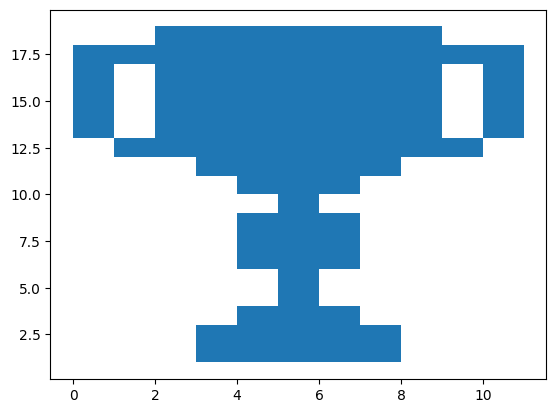

0.45351409912109375
0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0


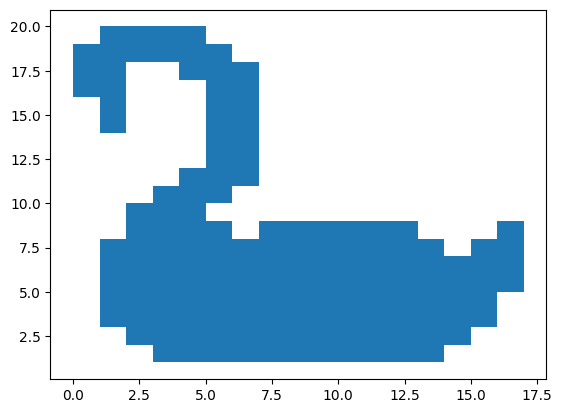

0.6660933494567871
0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 1 0 1 0 1 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 1 0 1 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 0 0 1 0 1 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 0 0 1 0 1 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 1 1 0 1 0 1 1 0 0 0
0 0 1 1 1 0 1 0 1 1 1 0 0
0 1 1 1 1 0 1 0 1 1 1 1 0
0 1 1 1 1 0 1 0 1 1 1 1 0
0 1 1 1 1 0 1 0 1 1 1 1 0
0 1 1 1 1 0 1 0 1 1 1 1 0
0 0 1 1 1 0 1 0 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 0 0 0 1 1 1 1 0
1 1 1 1 0 0 0 0 0 1 1 1 1
1 1 1 1 1 0 0 0 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 0 0 0 0 0 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0


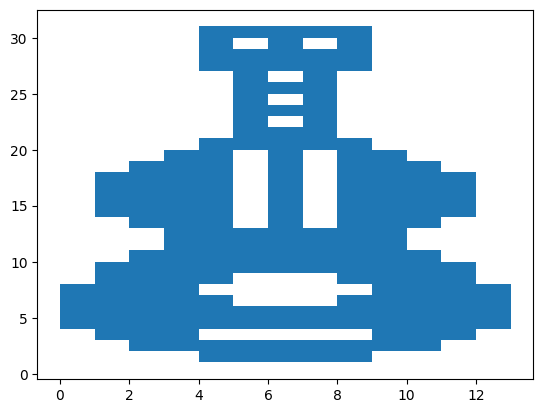

1.0570833683013916
1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0


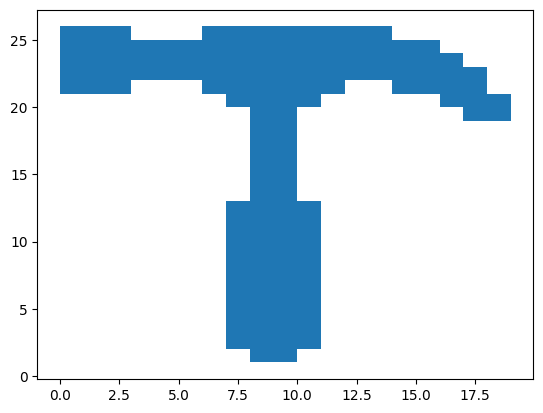

0.8200702667236328
0 0 1 1 1 0 0 0 1 1 1 0 0
0 1 1 1 1 1 0 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0


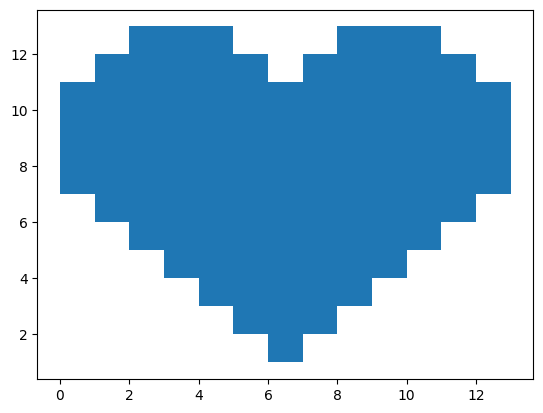

0.6097126007080078
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1
0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0
1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0
1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1
1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1
0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0


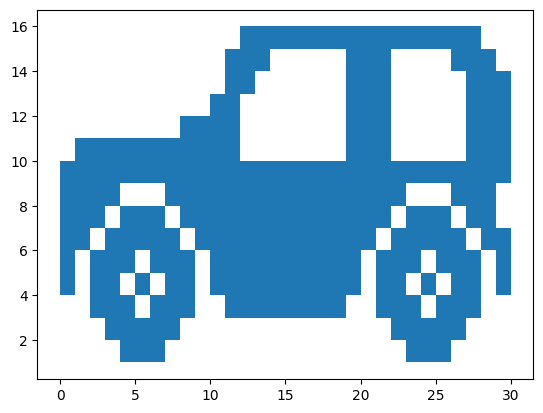

0.8298473358154297
0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0
1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0


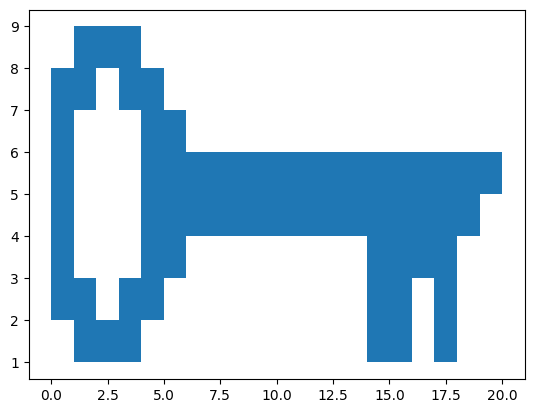

0.5404152870178223
0 0 0 0 1 0 0 0 0
0 0 0 0 1 1 0 0 0
0 0 0 0 1 1 1 0 0
0 0 0 0 1 1 1 0 0
0 0 0 0 1 0 1 0 0
0 0 0 0 1 0 1 0 0
0 0 0 0 1 0 1 0 0
0 0 0 1 1 0 0 0 0
0 0 1 1 1 0 0 0 0
0 1 1 0 1 0 0 0 0
1 1 0 0 1 1 1 0 0
1 1 0 1 1 0 1 1 0
1 1 0 1 1 0 0 1 1
1 1 0 0 1 0 0 1 1
1 1 0 0 1 0 0 1 1
0 1 1 0 1 0 1 1 0
0 0 1 1 1 1 1 0 0
0 0 0 0 1 0 0 0 0
0 0 0 0 1 0 0 0 0
0 0 0 0 1 1 0 0 0


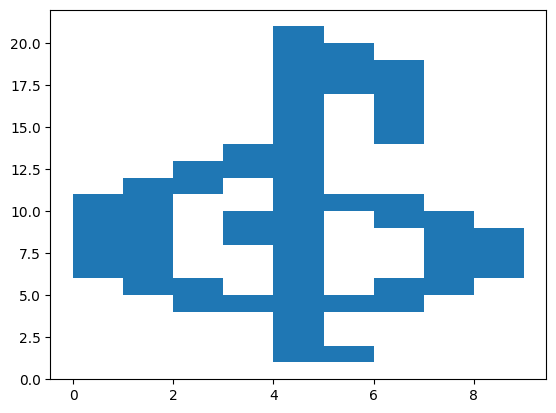

0.39418530464172363
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
0 1 1 1 1 1 

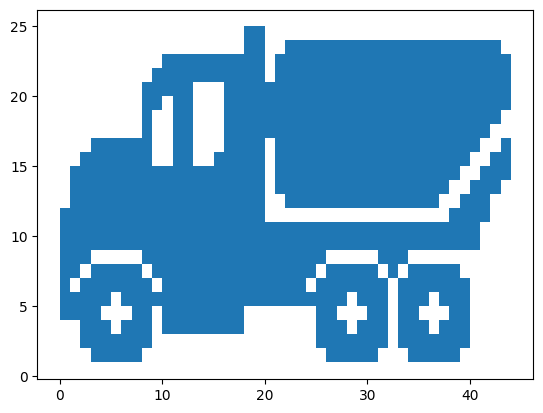

2.054934501647949
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1
1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0
0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0
0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0
0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0
0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0


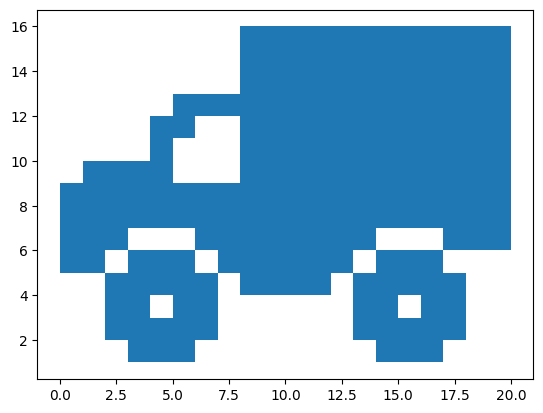

0.6940860748291016
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0
0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0
0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0
0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 0

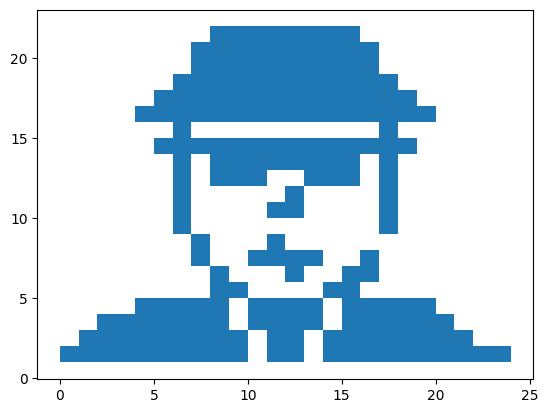

0.750607967376709
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 0 0 1 1 0 0 

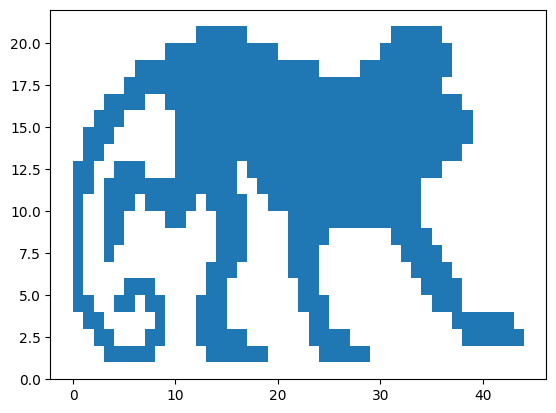

1.551128625869751
1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


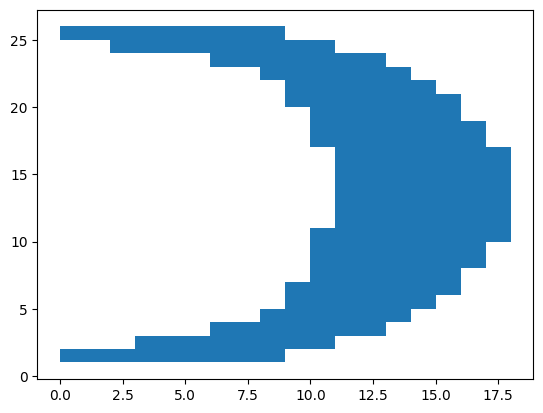

0.8375210762023926
0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0
0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0
1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
0 0 0 0 0 0 0 0

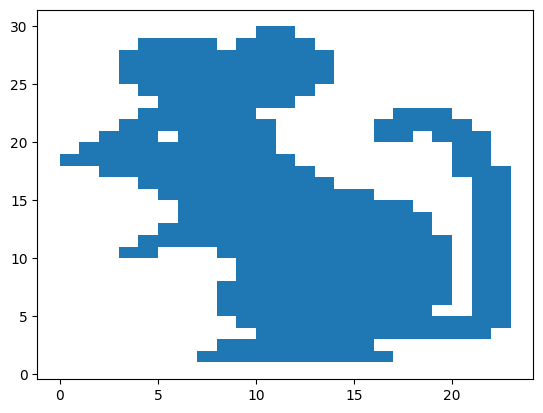

1.0445914268493652
0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0
1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0
0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0
0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0
0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1
0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0


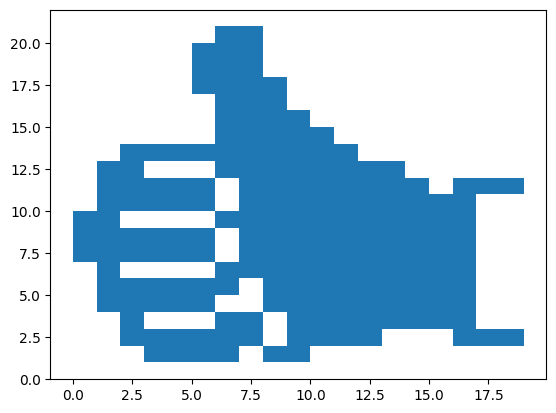

0.8631548881530762
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1
0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0
1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1
0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1
0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1
0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1
0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0

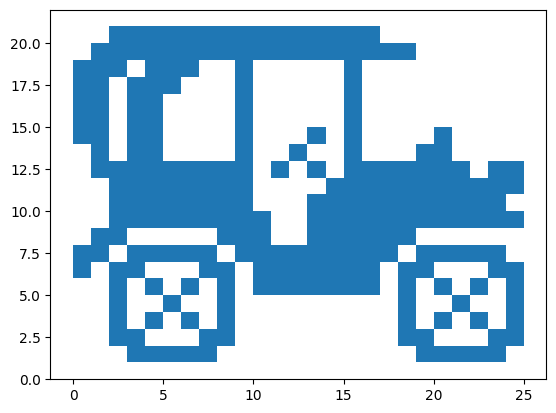

1.0180532932281494
0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0
0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0
0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1
0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1
0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1
0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1
0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1
0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1
1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1
1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0
1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0
1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 0

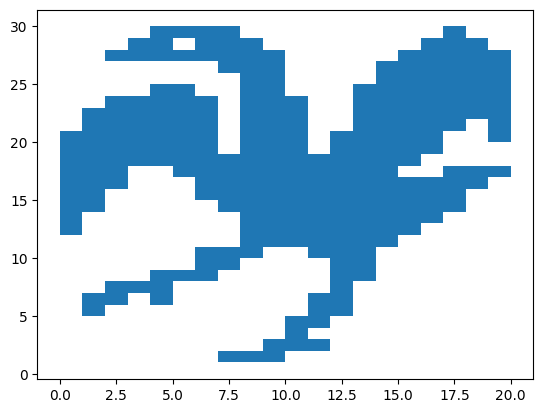

1.3022656440734863
0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0
1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1
0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0


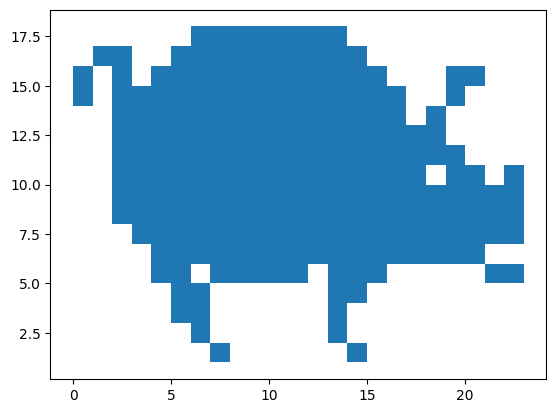

0.8747024536132812
0 0 1 1 1 1 0 0 0 0
0 1 1 0 1 1 1 0 0 0
1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 0 0
0 1 1 0 0 0 1 1 0 0
0 1 0 0 0 0 1 1 0 0
1 1 0 0 0 0 1 1 1 0
1 0 0 0 0 1 1 1 1 0
1 0 0 0 1 1 1 1 1 0
1 0 0 0 1 1 1 1 1 0
1 0 0 0 1 1 1 1 1 0
1 0 0 0 1 1 1 0 1 0
1 0 0 0 1 1 1 0 1 0
1 0 0 0 1 1 0 1 1 0
1 1 0 0 1 0 1 1 1 0
0 1 0 0 1 0 1 1 1 0
0 1 1 0 0 0 1 1 1 0
0 0 1 0 0 0 1 1 1 0
0 0 0 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1


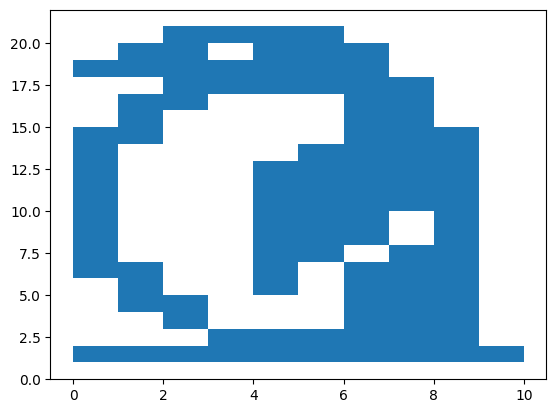

0.47998929023742676
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1
1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 

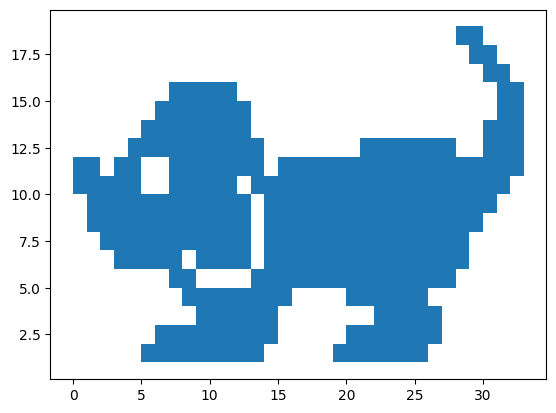

1.1338326930999756
0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0
0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0
0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0
0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0
0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0
0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0
0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1
1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1
1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1
1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1
0 1 1 1 1

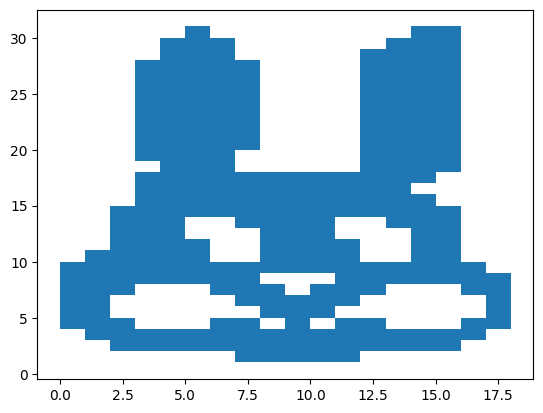

0.9849503040313721
0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0


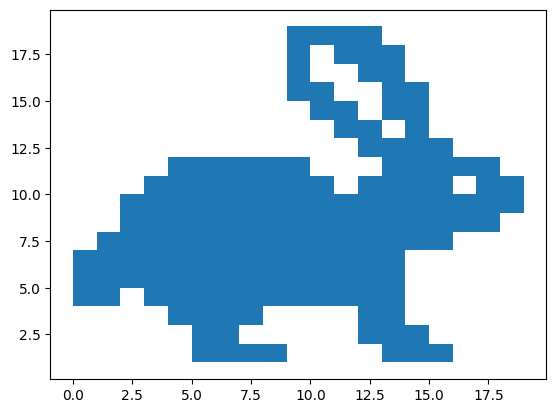

0.6365633010864258
0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
0 0 1 1 0 1 0 1 0 0 0 0 0 0 0
0 0 1 1 0 1 1 0 0 0 0 0 0 0 0
0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 1 1 0 0 0 0 1 1 1 1
0 0 0 0 0 1 0 0 0 0 0 0 1 0 1
0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
0 0 0 0 1 1 0 0 0 0 0 1 1 0 0


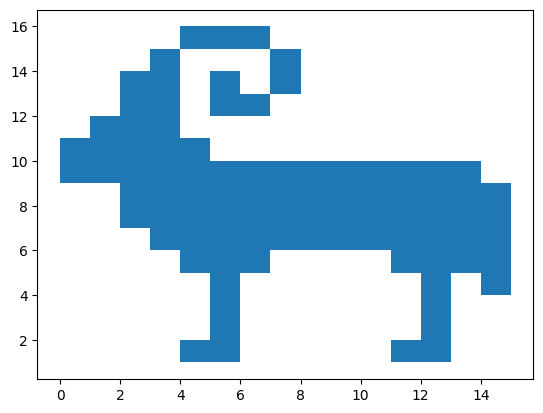

0.6563177108764648
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0

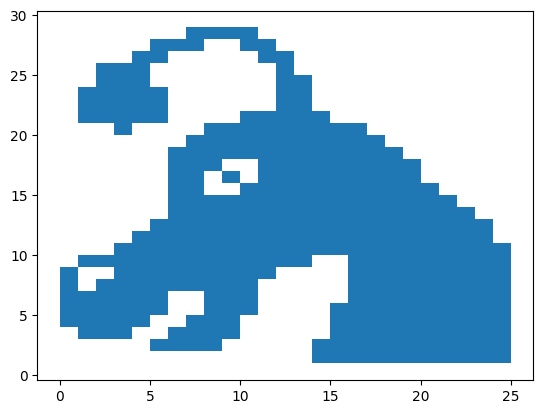

1.2072675228118896
1 1 1 1 1 1 1 1 1 1 1 1 1
1 0 0 0 0 0 0 0 0 0 0 0 1
1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 0 0 0 0 0 0 0 0 0 1 0
0 1 0 0 0 0 0 0 0 0 0 1 0
0 1 0 0 0 0 0 0 0 0 0 1 0
0 1 0 0 0 0 0 0 0 0 0 1 0
0 1 1 0 1 1 1 1 1 0 1 1 0
0 0 1 1 0 1 1 1 0 1 1 0 0
0 0 0 1 1 0 1 0 1 1 0 0 0
0 0 0 0 1 1 0 1 1 0 0 0 0
0 0 0 0 1 1 0 1 1 0 0 0 0
0 0 0 1 1 0 0 0 1 1 0 0 0
0 0 1 1 0 0 1 0 0 1 1 0 0
0 1 1 0 0 1 1 1 0 0 1 1 0
0 1 0 0 1 1 1 1 1 0 0 1 0
0 1 0 1 1 1 1 1 1 1 0 1 0
0 1 0 1 1 1 1 1 1 1 0 1 0
0 1 0 1 1 1 1 1 1 1 0 1 0
1 1 1 1 1 1 1 1 1 1 1 1 1
1 0 0 0 0 0 0 0 0 0 0 0 1
1 1 1 1 1 1 1 1 1 1 1 1 1


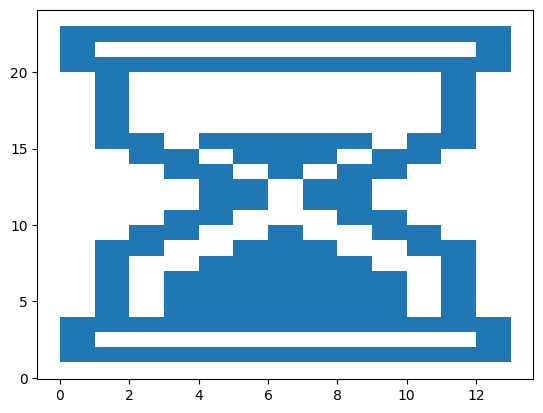

0.5930674076080322
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0
0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0
0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0
0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0
0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0
0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0
1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0
1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1
1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

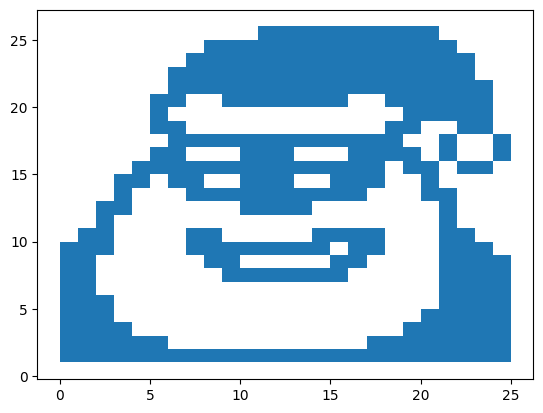

1.2262139320373535
0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1
0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0


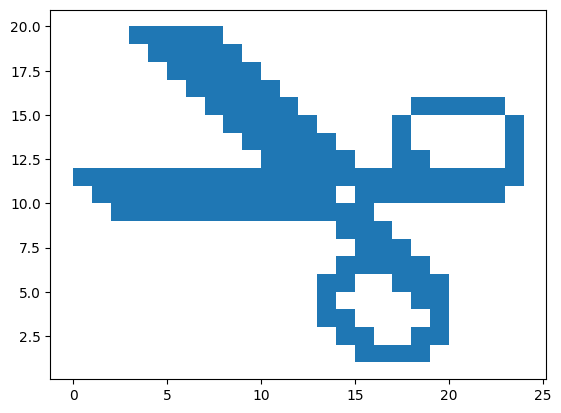

0.6794593334197998
0 0 1 1 1 1 0 0 0
0 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 0 1 0
1 1 1 1 0 1 1 1 1
1 1 1 1 0 0 0 0 0
1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 0 0 0
0 0 1 1 1 1 0 0 0
0 0 1 1 1 1 0 0 0
0 0 1 1 1 1 0 0 0
0 1 1 1 1 0 0 0 0
0 1 1 1 0 0 0 0 0
1 1 1 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0
0 1 1 0 0 0 1 0 0
0 0 1 1 1 1 0 0 0


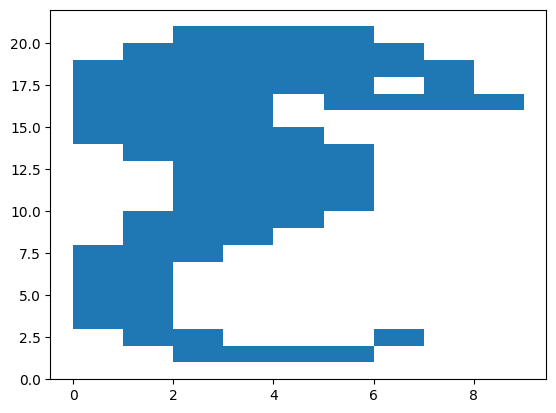

0.5576894283294678
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0

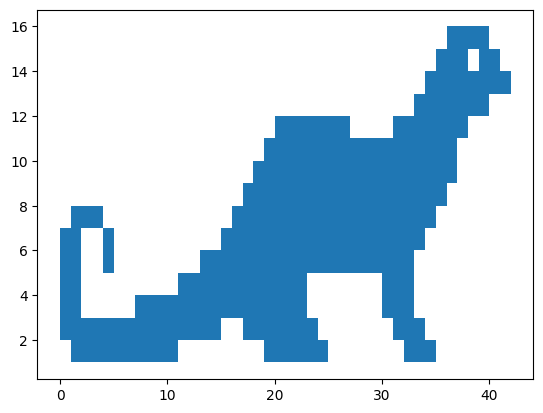

0.9594907760620117
0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0
0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0
1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0
1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0
1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0
1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0
1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0
1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0
0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0


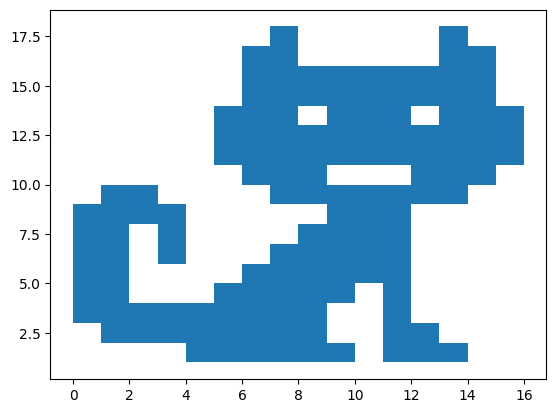

0.5511341094970703
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1
0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1
1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1
1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1
1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0
1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0
1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0


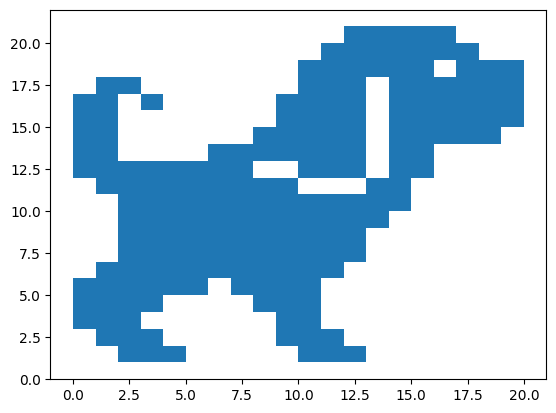

1.0648431777954102
0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0
1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0
1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0
0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1
0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0
0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1

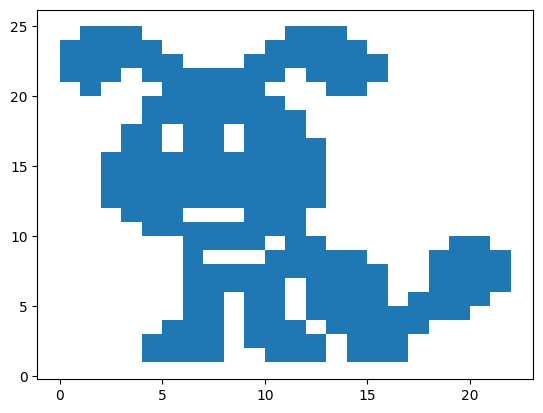

1.0107839107513428
0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0

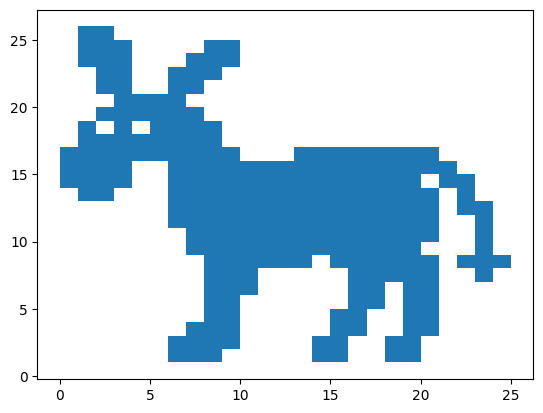

1.176274299621582
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0
0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0
0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0
0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0
0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1
1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1
0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0
0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0


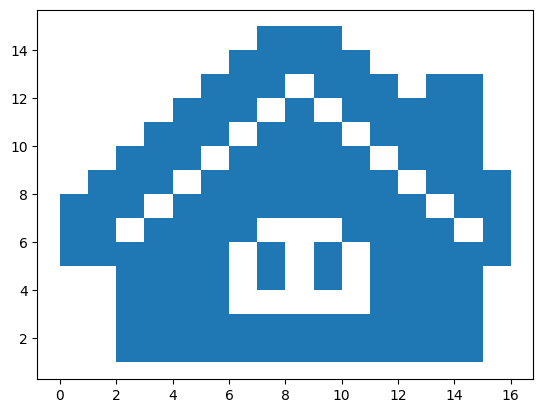

0.5420665740966797
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0


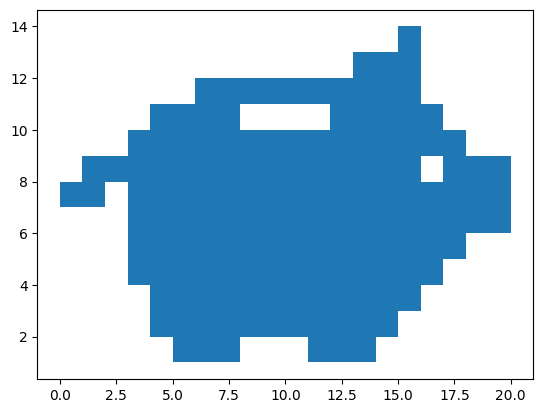

0.5813884735107422
0 0 0 0 1 1 0 0 0 0 0
0 0 0 1 1 1 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0
0 1 1 1 0 1 1 1 1 0 0
1 0 1 1 1 1 1 1 1 1 0
1 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 0 0 1 1 1 1
0 0 1 1 1 0 1 0 1 1 1


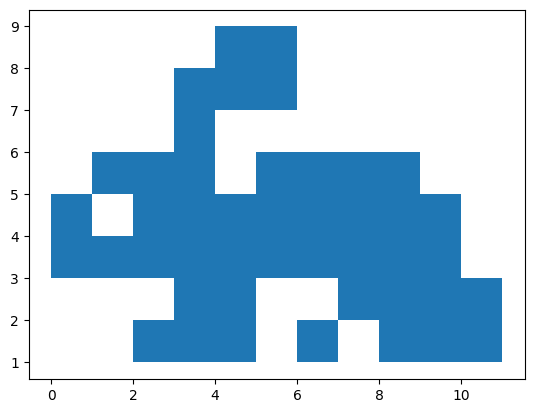

0.3152287006378174
0 0 0 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 0 0
0 1 1 1 1 1 1 1 1 1 0
1 1 0 0 0 1 0 0 0 1 1
1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1
1 1 0 1 1 1 1 1 0 1 1
1 1 1 0 0 0 0 0 1 1 1
0 1 1 1 0 0 0 1 1 1 0
0 0 1 1 1 1 1 1 1 0 0
0 0 0 1 1 1 1 1 0 0 0


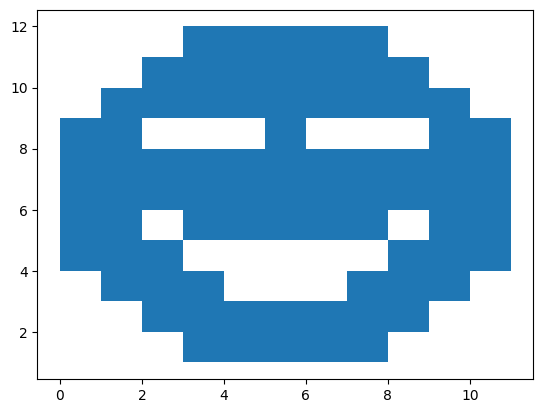

0.3801403045654297
0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0
1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0
1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0
1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1
0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1
0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0
0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0
0 0 0 0 0 0 0

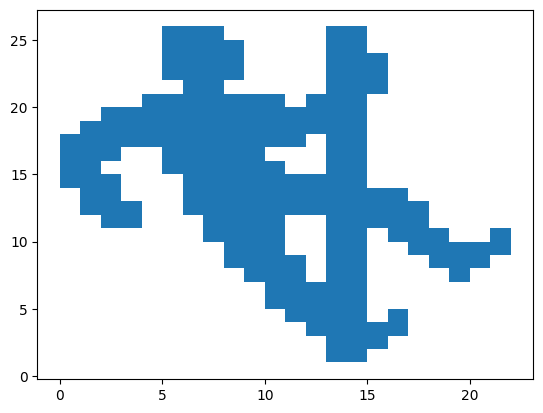

0.9426019191741943
0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1
0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0
0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0
0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0

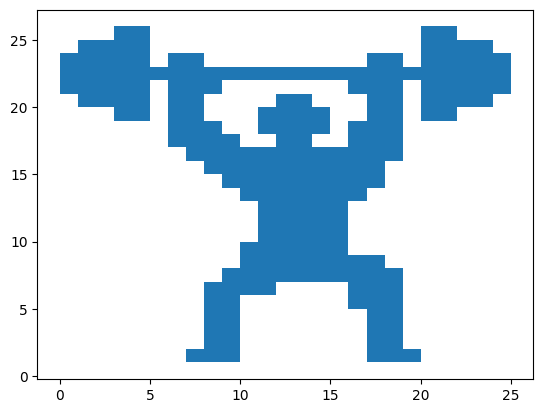

0.8753573894500732
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0
0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0
0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0
0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0
0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0
0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0
1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0

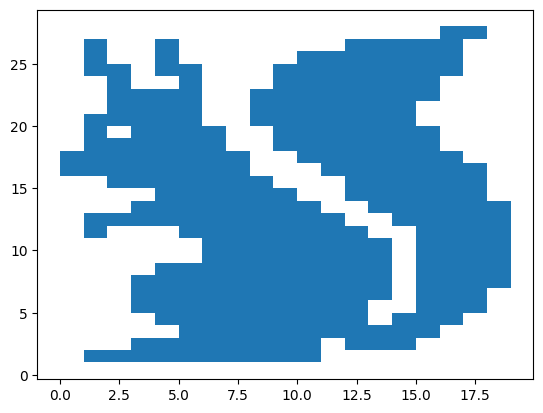

1.150216817855835
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0
0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0


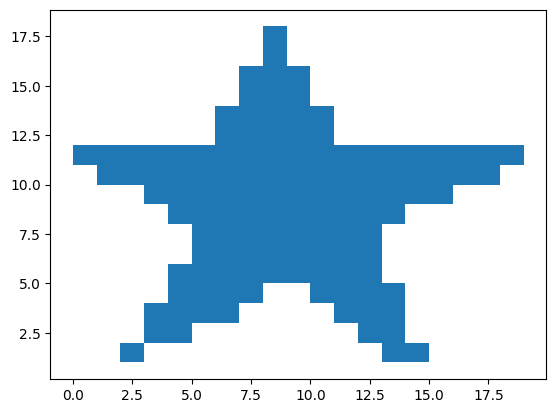

0.5812718868255615
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

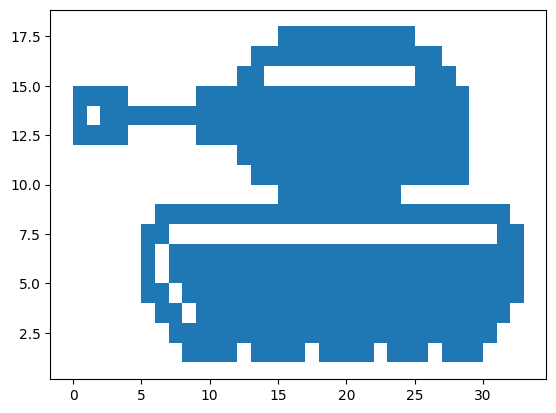

1.0292153358459473
0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0
0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1
0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0
0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0
0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0
0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0


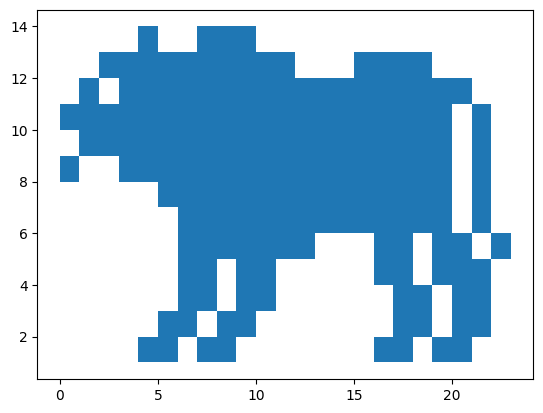

0.6444461345672607
0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0
0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0
0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0
0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0
1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0
0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0
0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0

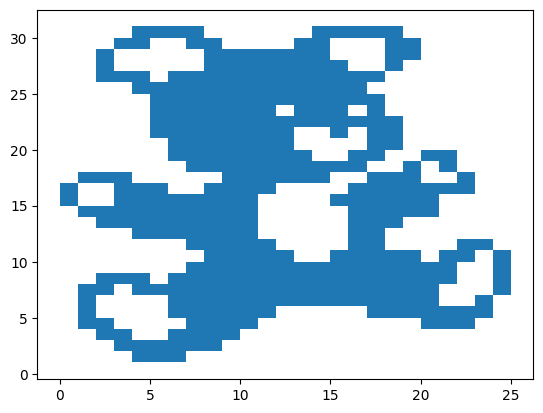

1.4256339073181152
0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1
1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1
1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1
1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1
1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1
1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1
1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1
1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


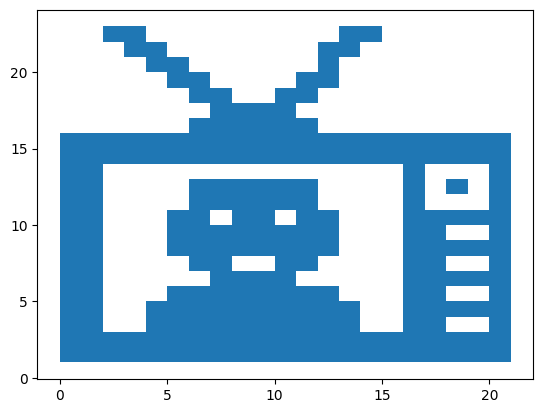

0.9758036136627197


In [72]:
for file in range(3,94):
  start_time = time.time()
  #convert data from file to array format
  line_number = 0
  rows = 0
  columns = 0
  all_rows = [] #the array of all blocks of filled cells in ROWS
  all_columns = [] #the array of all blocks of filled cells in COLUMNS
  if os.path.isfile("test" + str(file)+".txt"):
    with open("test" + str(file) + ".txt", "r") as file:
        for line in file:
            line_number += 1
            if line_number == 1:
                rows = int(line.split(" ")[0])
                columns = int(line.split(" ")[1])
            elif line_number <= 1 + rows:
                all_rows.append(list(map(int, line.split())))
            else:
                all_columns.append(list(map(int, line.split())))
  else:
    continue
  solutions = []
  previous = 0
  lennn = []
  max_num = rows*columns
  everything = []
  for i in range(rows):
      blocks = all_rows[i] #all filled in cells in the ith row
      if max_num%columns==0:
          ma = max_num
      else:
          ma = max_num + (columns-max_num%columns)
      if blocks==[0]: #case of the empty row
          for empty in range(i*columns+1, (i+1)*columns+1):
              solutions.append([-empty])
          continue
      all_starts = existence(blocks, columns, rows*columns, previous)
      exist  = all_starts[0] #array of all possible starting possitions of the blocks
      unique_start  = all_starts[1] #exclusion of two starts at the same time
      max_num = all_starts[2]
      min_num = all_starts[3]
      color = all_starts[4]
      for j in exist:
          solutions.append(j)
      for j in unique_start:
          solutions.append(j)
      for j in intersection(exist, blocks, columns):
          solutions.append(j)
      get = cell_rows(max_num, columns*rows, columns, i*columns, min_num, color, blocks,ma)
      colored = get[0]
      emptys = get[1]
      nothing  = get[2]
      d = get[3]
      for j in emptys:
          solutions.append(j)
      for j in colored:
          solutions.append(j)
      for j in nothing:
          solutions.append(j)
      for j in d:
          solutions.append(d[j])
      previous += len(blocks)
  previous = 0
  for column in range(columns):
      blocks = all_columns[column]
      got = existence(blocks, rows, rows*columns, previous)
      if column==0:
          if max_num%columns==0:
              mm = max_num
          else:
              mm = max_num + (columns-max_num%columns)
          att = mm-columns*rows
      if (max_num-att)%rows==0:
              mm = max_num
      else:
          mm = max_num + (rows-(max_num-att)%rows)
      if blocks==[0]:
          for h in range(column*rows+1, column*rows+rows+1):
              solutions.append([-(((h-1)%rows)*columns+(h-1)//rows+1)])
          continue
      sol_1 = []
      sol_2 = []
      solution_1  = got[0]
      solution_2  = got[1]
      for i in solution_1:
          solution_1_1 = []
          for j in i:
              solution_1_1.append(j+att)
          sol_1.append(solution_1_1)
      for i in solution_2:
          solution_2_1 = []
          for j in i:
              solution_2_1.append(-(j*(-1)+att))
          sol_2.append(solution_2_1)
      solution_1  = sol_1.copy()
      solution_2  = sol_2.copy()
      max_num = got[2]+att
      min_num = got[3]+att
      color = got[4]
      colll = []
      for i in color:
          colll.append(i+att)
      color = colll.copy()
      for j in solution_1:
          solutions.append(j)
      for j in solution_2:
          solutions.append(j)
      for j in intersection(solution_1, blocks, rows):
          solutions.append(j)
      get = cell_columns(max_num, columns*rows, rows, column*rows, min_num, color, columns,column, blocks, mm)
      colored = get[0]
      emptys = get[1]
      nothing  = get[2]
      nj = get[3]
      for j in emptys:
          solutions.append(j)
      for j in colored:
          solutions.append(j)
      for j in nothing:
          solutions.append(j)
      for j in nj:
          solutions.append(nj[j])
      previous += len(blocks)
  solved = pycosat.solve(solutions)
  fig, ax = plt.subplots()
  ax.plot()
  if solved!='UNSAT':
      for i in range(rows*columns):
          if i%columns==(columns-1):
              if solved[i]<0:
                  print(0)
              else:
                  print(1)
                  ax.add_patch(Rectangle((i%columns,rows-i//columns), 1, 1))
          else:
              if solved[i]<0:
                  print(0, end=" ")
              else:
                  print(1, end=" ")
                  ax.add_patch(Rectangle((i%columns,rows-i//columns), 1, 1))
  plt.show()
  end_time = time.time()
  print(end_time - start_time)